## Домашняя работа 4. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('./data.adult.csv')
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


In [2]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**(0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [3]:
data = data.replace('?', np.nan)
data.shape

(16280, 14)

In [4]:
data.dropna(inplace=True)
data.shape

(15347, 14)

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [5]:
X = data.drop(columns='>50K,<=50K')
y = data['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)
y

0        0
1        0
2        0
3        0
4        1
        ..
16275    0
16276    1
16277    0
16278    0
16279    1
Name: >50K,<=50K, Length: 15347, dtype: int64

In [6]:
numericData = data._get_numeric_data()
X_num = numericData
numericData.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 5-fold cv.

**(1.5 балла)** Для каждого из первых двух алгоритмов подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [22]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn import model_selection
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [12]:
np.random.seed(13)
k_range = np.arange(start=1, stop=100, step=2)
knn_params = dict(n_neighbors=k_range)

knn = KNeighborsClassifier()

knn_grid = GridSearchCV(knn, cv=5, param_grid=knn_params, n_jobs=8)
knn_grid.fit(X_num, y)

print('best score:', knn_grid.best_score_)
print('best params:', knn_grid.best_params_)

best score: 0.7817163332388718
best params: {'n_neighbors': 19}


In [51]:
np.random.seed(123)
sgd_params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
}
sgd = SGDClassifier(max_iter=10000, tol=1e-3)

grid_sgd = GridSearchCV(sgd, cv=5, param_grid=sgd_params,n_jobs=8)
grid_sgd.fit(X_num, y)

print('best score:', grid_sgd.best_score_)
print('best params:', grid_sgd.best_params_)

best score: 0.7768304246627248
best params: {'loss': 'modified_huber'}


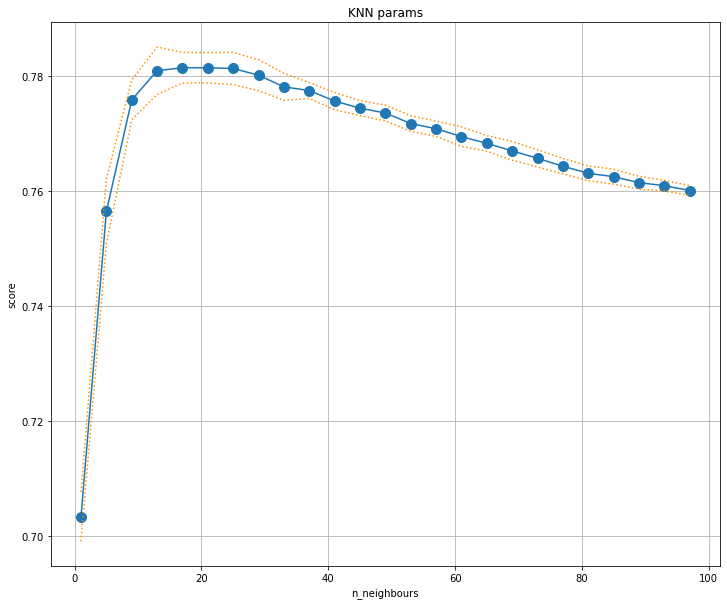

In [29]:
x = k_range
y = knn_grid.cv_results_['mean_test_score'] 
dov_int_l = knn_grid.cv_results_['mean_test_score'] - knn_grid.cv_results_['std_test_score']
dov_int_r = knn_grid.cv_results_['mean_test_score'] + knn_grid.cv_results_['std_test_score']


plt.figure(figsize = (12, 10))

plt.grid()
plt.title("KNN params") 
plt.xlabel("n_neighbours")
plt.ylabel("score") 
plt.plot(x, y, marker=".", markersize=20)
plt.plot(x, dov_int_l, color="darkorange", linestyle='dotted');
plt.plot(x, dov_int_r, color="darkorange", linestyle='dotted');


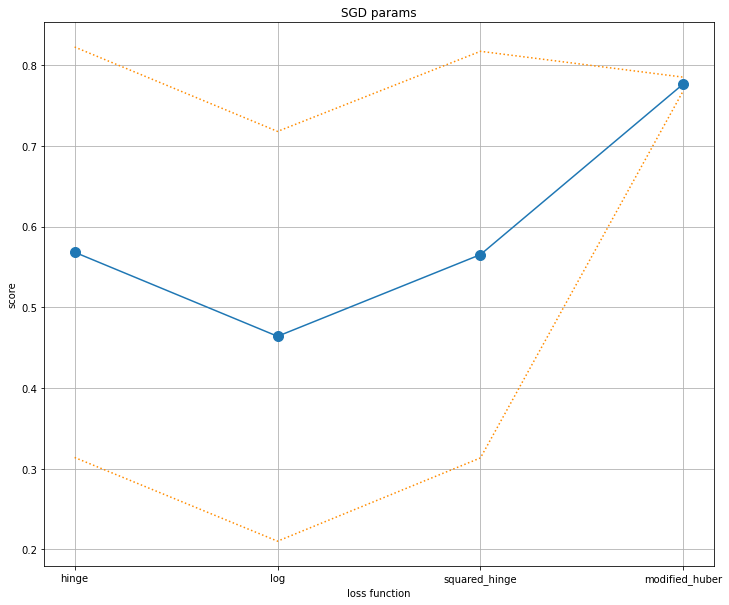

In [52]:
x = sgd_params['loss']
y = grid_sgd.cv_results_['mean_test_score'] 
dov_int_l = grid_sgd.cv_results_['mean_test_score'] - grid_sgd.cv_results_['std_test_score']
dov_int_r = grid_sgd.cv_results_['mean_test_score'] + grid_sgd.cv_results_['std_test_score']


plt.figure(figsize = (12, 10))

plt.grid()
plt.title("SGD params") 
plt.xlabel("loss function") 
plt.ylabel("score") 
plt.plot(x, y, marker=".", markersize=20)
plt.plot(x, dov_int_l, color="darkorange", linestyle='dotted');
plt.plot(x, dov_int_r, color="darkorange", linestyle='dotted');

Можно заметить, что на графике также явно выделяются параметры, которые дают наилучшее качество. В SGD - функция modified_huber и для KNN оптимальное число соседей 17

Что вы можете сказать о получившихся графиках?

**(0.75 балла)** Также подберём параметр регуляризации C в алгоритмах LogisticRegression и SVC.

In [89]:
from sklearn.linear_model import LogisticRegression
np.random.seed(123)

c_range = np.geomspace(1e-1, 1e-6, num=6)
lr_params = dict(C=c_range)

lr = LogisticRegression()

lr_grid = GridSearchCV(lr, cv=5, param_grid=lr_params, n_jobs=8)
lr_grid.fit(X_num, y)

print('best score:', lr_grid.best_score_)
print('best params:', lr_grid.best_params_)

best score: 0.7847789866724405
best params: {'C': 0.1}


In [36]:
from sklearn.svm import SVC
np.random.seed(123)

svc_range = [1, 10, 100, 200, 500, 1000]
svc_params = dict(C=svc_range)

svc = SVC(kernel='rbf')

svc_grid = GridSearchCV(svc, cv=5, param_grid=svc_params, n_jobs=8)
svc_grid.fit(X_num, y)

print('best score:', svc_grid.best_score_)
print('best params:', svc_grid.best_params_)

best score: 0.7874505271268957
best params: {'C': 200}


**(0.75 балла)** Изучите документацию по алгоритму [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) и подберите возможные гиперпараметры для этого алгоритма.

In [93]:
g_range = np.geomspace(1e-1, 1e-12, num=6)
gauss_params = {'var_smoothing': g_range}

gs = GaussianNB()
gs_grid = GridSearchCV(gs, cv=5, param_grid=gauss_params, n_jobs=8)
gs_grid.fit(X_num, y)

print('best score:', gs_grid.best_score_)
print('best params:', gs_grid.best_params_)

best score: 0.786277549053634
best params: {'var_smoothing': 0.000630957344480193}


При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**(0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

<AxesSubplot:>

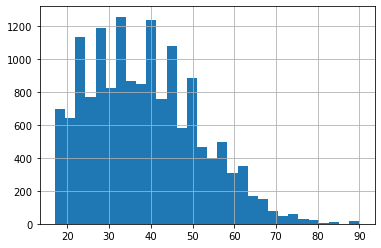

In [94]:
X_num.age.hist(bins=30)

<AxesSubplot:>

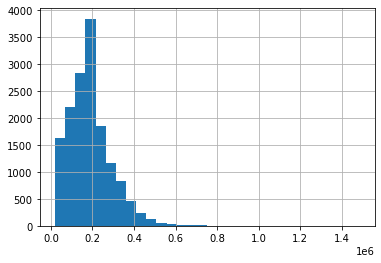

In [95]:
X_num.fnlwgt.hist(bins=30)

<AxesSubplot:>

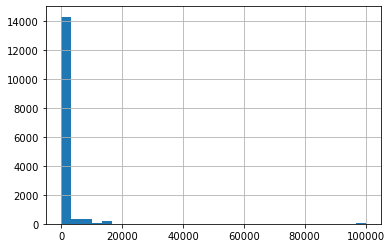

In [96]:
X_num['capital-gain'].hist(bins=30)

Признаки лежат в разных интервалах: [15, 90], [0,1], [0, 20000]. При этом для capital-gain почти все значения находятся ближе к нулю, но есть значения, выходящие за 10к. Масштабирование признаков напрямую повлияет, например, на knn с евкл мерой расстояния и метод опорных векторов, а также логистическую регрессию

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [40]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_num_ss = ss.fit_transform(X_num)
X_num_ss = pd.DataFrame(X_num_ss, columns = X_num.columns)
X_num_ss.head()


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.342919,0.900258,-0.450788,-0.065600,-0.21874,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.21874,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.21874,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.21874,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.21874,-0.074178


In [16]:
# knn
# best score: 0.7815210208632506
knn_grid.fit(X_num_ss, y)

print('best score:', knn_grid.best_score_)
print('best params:', knn_grid.best_params_)

best score: 0.8125366303573722
best params: {'n_neighbors': 51}


In [99]:
# sgd
# best score: 0.7768304246627248
grid_sgd.fit(X_num_ss, y)

print('best score:', gs_grid.best_score_)
print('best params:', gs_grid.best_params_)

best score: 0.786277549053634
best params: {'var_smoothing': 0.000630957344480193}


In [100]:
# logistic regr
# best score: 0.7847789866724405
lr_grid.fit(X_num_ss, y)

print('best score:', lr_grid.best_score_)
print('best params:', lr_grid.best_params_)

best score: 0.8054996959189458
best params: {'C': 0.1}


In [39]:
# svm
# best score: 0.7952042862161598

svc_grid.fit(X_num_ss, y)

print('best score:', svc_grid.best_score_)
print('best params:', svc_grid.best_params_)

best score: 0.8163808092483095
best params: {'C': 10}


In [103]:
# gauss
# best score: 0.786277549053634
gs_grid.fit(X_num_ss, y)

print('best score:', gs_grid.best_score_)
print('best params:', gs_grid.best_params_)

best score: 0.7903822081272959
best params: {'var_smoothing': 0.1}


Изменилось ли качество у некоторых алгоритмов?

Да качество улучшилось у всех алгоритмов

**(1,5 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае, например:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Для оставшихся трех алгоритмов самостоятельно определите, какие наборы гиперпараметров необходимо перебирать и осуществите перебор.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой.

In [26]:
# KNN parameters combinations
params = {
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'n_neighbors': np.arange(start=1, stop=50, step=2)
}
knn_grid_n = GridSearchCV(estimator=KNeighborsClassifier(),           
                    param_grid=params, 
                    cv=5,
                    n_jobs=8)
knn_grid_n.fit(X_num_ss, y)

print('best score:', knn_grid_n.best_score_)
print('best params:', knn_grid_n.best_params_)

best score: 0.8136443769416346
best params: {'metric': 'manhattan', 'n_neighbors': 37}


In [33]:
# SGDClassifier parameters combinations
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': np.geomspace(1e-1, 1e-6, num=6),
    'max_iter': [10000]
}

grid_sgd_n = GridSearchCV(estimator=SGDClassifier(),           
                    param_grid=params, 
                    cv=5,
                    n_jobs=8)
grid_sgd_n.fit(X_num_ss, y)

print('best score:', grid_sgd_n.best_score_)
print('best params:', grid_sgd_n.best_params_)

/Users/elena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/elena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/elena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/elena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/elena

best score: 0.8051738568834292
best params: {'alpha': 0.01, 'loss': 'modified_huber', 'max_iter': 10000, 'penalty': 'l2'}


In [155]:
# Logistic regression parameters combinations
np.random.seed(123)
params = {
    "C" : np.geomspace(1e-1, 1e-6, num=6),
    'solver': ['newton-cg', 'lbfgs','liblinear', 'sag', 'saga'],
}

grid_lr_n = GridSearchCV(estimator=LogisticRegression(),           
                    param_grid=params, 
                    cv=5,
                    n_jobs=8)
grid_lr_n.fit(X_num_ss, y)

print('best score:', grid_lr_n.best_score_)
print('best params:', grid_lr_n.best_params_)

best score: 0.805825471272566
best params: {'C': 0.1, 'solver': 'liblinear'}


In [45]:
# Опорные вектора parameters combinations
params = {
    "C" : [1, 50, 100, 200, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'],
}
grid_svc_n = GridSearchCV(estimator=SVC(),           
                    param_grid=params, 
                    cv=5, n_jobs=4)
                
grid_svc_n.fit(X_num_ss, y)

print('best score:', grid_svc_n.best_score_)
print('best params:', grid_svc_n.best_params_)

# Приношу извинения, но не успеваю еще раз посчитать. Случайно стерла результаты, пересчитав ячейку,
# а заново они считаются очень долго. При этом график - ящик с усами - есть в последней ячейке


/Users/elena/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [23]:
# Gauss parameters combinations
# не будем изменять priors напрямую, тк данные параметры не улучшат качество модели, если их не знать
params = {
    "var_smoothing" : np.geomspace(1e-1, 1e-12, num=6),
}

grid_gs_n = GridSearchCV(estimator=GaussianNB(),           
                    param_grid=params, 
                    cv=5,
                    n_jobs=8)
grid_gs_n.fit(X_num_ss, y)

print('best score:', grid_gs_n.best_score_)
print('best params:', grid_gs_n.best_params_)

best score: 0.7903822081272959
best params: {'var_smoothing': 0.1}


Наилучшее качество дают KNN и метод опорных векторов, но метод опорных векторов работает дольше всего. Требуемые ресурсы к вычислениям SVM быстро возрастают с увеличением количества обучающих векторов. Более того, SVM обучение на квадратичном ядре rbf, согласно документации, примерно соответствует сложности: O(n_samples^2 * n_features)
Также хорошее качество показали логистическая регрессия и SGD

Какой из алгоритмов имеет наилучшее качество? 

**(0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**(0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [49]:
from sklearn.pipeline import Pipeline
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import cross_val_score


In [128]:
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship','race', 'sex']
pipeline_knn = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', KNeighborsClassifier(metric='manhattan', n_neighbors=37))
])
pipeline_sgd = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', SGDClassifier(alpha=0.001, loss='log', max_iter =10000, penalty= 'l1'))
])
pipeline_lr = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LogisticRegression(C=0.1, solver='liblinear'))
])
pipeline_svc = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', SVC(C=10, kernel='rbf', probability=True))
])
pipeline_gs = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', GaussianNB(var_smoothing = 0.1))
])

Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

**(0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [139]:
#your code here

cv_res_knn = cross_val_score(pipeline_knn, X, y, cv=5)
cv_res_knn.mean()

0.8356681663753219

In [77]:
cv_res_sgd = cross_val_score(pipeline_sgd, X, y, cv=5).mean()
cv_res_sgd

0.8394470076407663

In [93]:
cv_res_lr = cross_val_score(pipeline_lr, X, y, cv=5).mean()
cv_res_lr

0.8412713453755799

In [95]:

cv_res_svc = cross_val_score(pipeline_svc, X, y, cv=5).mean()
cv_res_svc

0.8458977926793414

In [94]:

cv_res_gs = cross_val_score(pipeline_gs, X, y, cv=5).mean()
cv_res_gs

0.8302596417044248

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Качество моделей еще более выровнилось. Метод опорных векторов по-прежнему на первом месте, но knn уже не показываует таких же лучших результатов. Теперь на втором месте качества логистическая регрессия

## Смешивание моделей

Во всех предыдущих пунктах мы получили много хороших моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и логистическая регрессия). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**(1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [122]:
from sklearn.ensemble import VotingClassifier

alpha = np.arange(0, 1.1, 0.25)
weights = list(zip(alpha, (1-alpha)))

params_vclf = {
            'voting': ['soft'],
            'weights': weights
}
        
vclf = VotingClassifier(estimators=[('svc', pipeline_svc), ('lr', pipeline_lr)])
vclf_grid = GridSearchCV(estimator = vclf,
                       param_grid = params_vclf,
                       cv = 5)
vclf_grid.fit(X, y)
print('best score:', vclf_grid.best_score_)
print('best params:', vclf_grid.best_params_)

best score: 0.8481134556662558
best params: {'voting': 'soft', 'weights': (0.5, 0.5)}


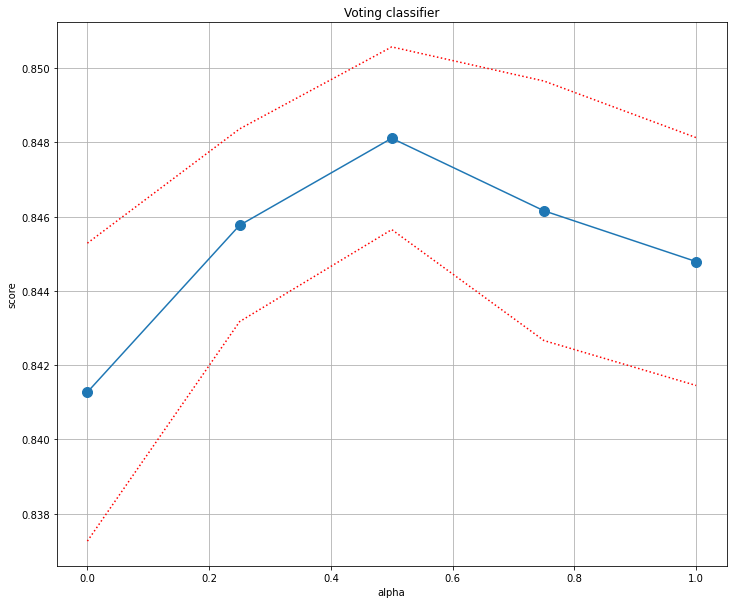

In [123]:
x = alpha
y = vclf_grid.cv_results_['mean_test_score'] 
dov_int_l = vclf_grid.cv_results_['mean_test_score'] - vclf_grid.cv_results_['std_test_score']
dov_int_r = vclf_grid.cv_results_['mean_test_score'] + vclf_grid.cv_results_['std_test_score']


plt.figure(figsize = (12, 10))

plt.grid()
plt.title("Voting classifier") 
plt.xlabel("alpha")
plt.ylabel("score") 
plt.plot(x, y, marker=".", markersize=20)
plt.plot(x, dov_int_l, color="red", linestyle='dotted');
plt.plot(x, dov_int_r, color="red", linestyle='dotted');

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**(1 балл)** Для каждого типа классификатора (kNN, SGD classifier и т.д.), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

<AxesSubplot:>

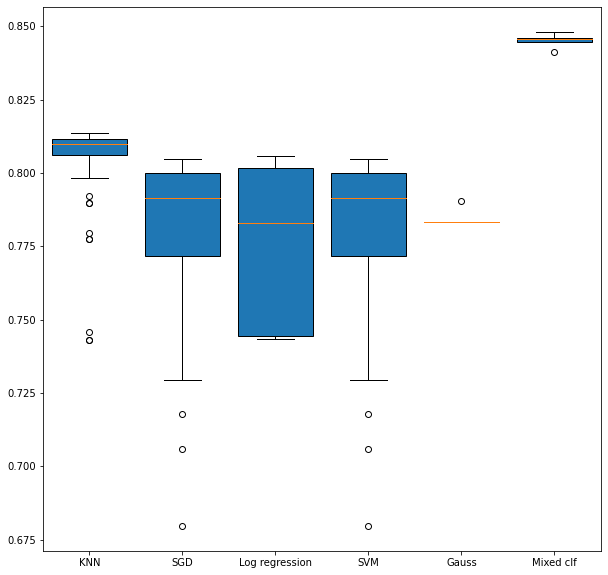

In [201]:
my_dict = {
    'KNN': knn_grid_n.cv_results_['mean_test_score'],
    'SGD': grid_sgd_n.cv_results_['mean_test_score'],
    'Log regression': grid_lr_n.cv_results_['mean_test_score'],
    'SVM': grid_sgd_n.cv_results_['mean_test_score'],
    'Gauss': grid_gs_n.cv_results_['mean_test_score'],
    'Mixed clf': vclf_grid.cv_results_['mean_test_score'],
        }

fig, ax = plt.subplots(figsize=(10, 10))

ax.boxplot(my_dict.values(), widths = 0.8, patch_artist = True)
ax.set_xticklabels(my_dict.keys())
ax

У KNN основной гиперпараметры - это число соседей, метрика и алгоритм. Число соседей напрямую влияет на качества алгоритма и обязательно должен настраиваться, но при слишком большом количестве возможно переобучение, что тоже слудет контролировать. SGD - оптимизируемая функция, penalty и альфа, те вес регуляризируемой функции. Выбор функции потери необходимо настраивать с весом альфа. В логистической регрессии я настраивала параметр С и solver, алгоритм  для оптимизации, для выбранного алгоритма можно будет подобрать уже наиболее оптимальный penalty, тк каждый из них поддерживает свой набор penalty. В методе опорных векторов также есть параметр C, отвечающий за регуляризацию. Чем он больше, тем шире разделяющая полоса. Для гаусса выбирала var_smoothing, который согласно документации, настраивает долю наибольшей дисперсии, которая может быть добавлена к остальным дисперсиям для стабильного вычисления.